在本练习中，您将实现正则化的线性回归和多项式回归，并使用它来研究具有不同偏差-方差属性的模型

# Regularized Linear Regression 正则线性回归
在前半部分的练习中，你将实现正则化线性回归，以预测水库中的水位变化，从而预测大坝流出的水量。在下半部分中，您将通过一些调试学习算法的诊断，并检查偏差 v.s. 方差的影响。

## Visualizing the dataset
我们将从可视化数据集开始，其中包含水位变化的历史记录，x，以及从大坝流出的水量，y。

这个数据集分为了三个部分：

training set 训练集：训练模型；
cross validation set 交叉验证集：选择正则化参数；
test set 测试集：评估性能，模型训练中不曾用过的样本。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

In [2]:
path = 'ex5data1.mat'
data = loadmat(path)
# Training set
X, y = data['X'], data['y']
# Cross c=validation set
Xval, yval = data['Xval'], data['yval']
# Test set
Xtest, ytest = data['Xtest'], data['ytest']
# Insert a column of 1s to all of the X, as usual
X = np.insert(X, 0, 1, axis=1)
Xval = np.insert(Xval, 0, 1, axis=1)
Xtest = np.insert(Xtest, 0, 1, axis=1)

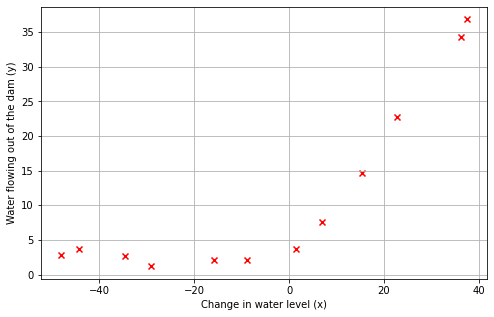

In [3]:
def plotData():
    """展示数据"""
    plt.figure(figsize=(8,5))
    plt.scatter(X[:,1:],y,c='r',marker='x')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.grid(True)
plotData()

## Regularized linear regression cost function

In [4]:
def costReg(theta,X,y,l):
    '''do not regularizethe theta0
    theta is a 1-d array with shape (n+1,)
    X is a matrix with shape (m, n+1)
    y is a matrix with shape (m, 1)
    '''
    cost=((X@theta-y.flatten())**2).sum()
    regterm=l*theta[1:].T@theta[1:]
    return (cost+regterm)/(2*len(y))

Using theta initialized at [1, 1], and lambda = 1, you should expect to see an output of 303.993192

In [5]:
theta=np.ones(X.shape[1])
print(costReg(theta,X,y,1))

303.9931922202643


## Regularized linear regression gradient

In [6]:
def gradientReg(theta,X,y,l):
    """
    theta: 1-d array with shape (2,)
    X: 2-d array with shape (12, 2)
    y: 2-d array with shape (12, 1)
    l: lambda constant
    grad has same shape as theta (2,)
    """
    grad=(X@theta-y.flatten())@X
    regterm=l*theta
    regterm[0]=0 # don't regulate bias term
    return (grad+regterm)/len(y)

# Using theta initialized at [1; 1] you should expect to see a 
# gradient of [-15.303016; 598.250744] (with lambda=1)
print(gradientReg(theta, X, y, 1))

[-15.30301567 598.25074417]


## Fitting linear regression 拟合线性回归

In [7]:
def trainLinearReg(X,y,l):
    theta=np.zeros(X.shape[1])
    res=opt.minimize(fun=costReg,x0=theta,args=(X,y,l),method='TNC',jac=gradientReg)
    return res.x

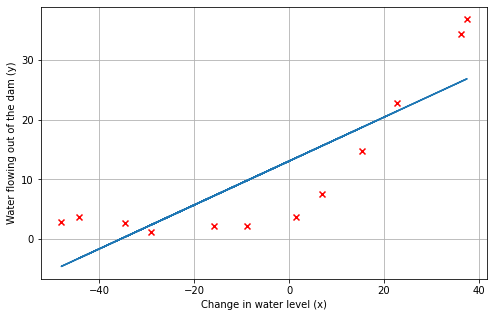

In [8]:
fit_theta=trainLinearReg(X,y,0)
plotData()
plt.plot(X[:,1],X@fit_theta)

这里我们把λ = 0，因为我们现在实现的线性回归只有两个参数，这么低的维度，正则化并没有用。

从图中可以看到，拟合最好的这条直线告诉我们这个模型并不适合这个数据。

在下一节中，您将实现一个函数来生成学习曲线，它可以帮助您调试学习算法，即使可视化数据不那么容易。

# Bias-variance
机器学习中一个重要的概念是偏差（bias）和方差（variance）的权衡。高偏差意味着欠拟合，高方差意味着过拟合。

在这部分练习中，您将在学习曲线上绘制训练误差和验证误差，以诊断bias-variance问题。

## Learning curves 学习曲线
训练样本X从1开始逐渐增加，训练出不同的参数向量θ。接着通过交叉验证样本Xval计算验证误差。

使用训练集的子集来训练模型，得到不同的theta。

通过theta计算训练代价和交叉验证代价，切记此时不要使用正则化，将 λ = 0 \lambda = 0λ=0。

计算交叉验证代价时记得整个交叉验证集来计算，无需分为子集。

In [9]:
def learningCurve(X, y, Xval, yval, l):
    """画出学习曲线，即交叉验证误差和训练误差随样本数量的变化的变化"""
    training_cost,cv_cost=[],[]
    xx= range(1,len(y)+1)
    for i in xx:
        res = trainLinearReg(X[:i],y[:i],l)
        training_cost_i=costReg(res,X[:i],y[:i],0)
        cv_cost_i=costReg(res,Xval,yval,0)
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
    
    plt.figure(figsize=(8,5))
    plt.plot(xx,training_cost,label='training cost')
    plt.plot(xx,cv_cost,label='cv cost')
    plt.legend()
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Learning curve for linear regression')
    plt.grid(True)

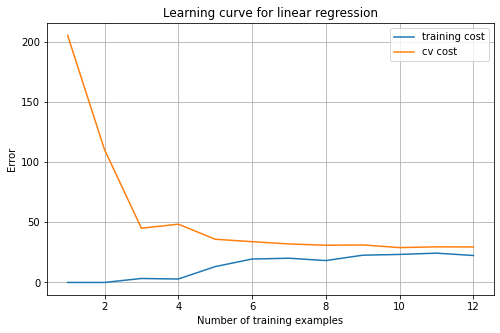

In [10]:
learningCurve(X, y, Xval, yval, 0)

从图中看出来，随着样本数量的增加，训练误差和交叉验证误差都很高，这属于高偏差，欠拟合。

# Polynomial regression 多项式回归
我们的线性模型对于数据来说太简单了，导致了欠拟合(高偏差)。在这一部分的练习中，您将通过添加更多的特性来解决这个问题。

## Learning Polynomial Regression
数据预处理

X，Xval，Xtest都需要添加多项式特征，这里我们选择增加到6次方，因为若选8次方无法达到作业pdf上的效果图，这是因为scipy和octave版本的优化算法不同。

不要忘了标准化。

In [11]:
def polyFeatures(X,power):
    """添加多项式特征
    每次在array的最后一列插入第二列的i+2次方（第一列为偏置）
    从二次方开始开始插入（因为本身含有一列一次方）
    """
    Xpoly=X.copy()
    for i in range(2,power+1):
        Xpoly=np.insert(Xpoly,Xpoly.shape[1],np.power(Xpoly[:,1],i),axis=1)
    return Xpoly

def get_means_std(X):
    """获取训练集的均值和误差，用来标准化所有数据。"""
    means=np.mean(X,axis=0)
    stds=np.std(X,axis=0,ddof=1)  # ddof=1 means 样本标准差
    return means,stds

def featureNormalize(X,means,stds):
    X_norm=X.copy()
    X_norm[:,1:]=(X_norm[:,1:]-means[1:])/stds[1:]
    return X_norm

关于归一化，所有数据集应该都用训练集的均值和样本标准差处理。切记。所以要将训练集的均值和样本标准差存储起来，对后面的数据进行处理。

而且注意这里是样本标准差而不是总体标准差，使用np.std()时，将ddof=1则是样本标准差，默认=0是总体标准差。而pandas默认计算样本标准差。

获取添加多项式特征以及 标准化之后的数据。


In [12]:
power=6

train_means,train_stds=get_means_std(polyFeatures(X,power))
X_norm=featureNormalize(polyFeatures(X,power),train_means,train_stds)
Xval_norm=featureNormalize(polyFeatures(Xval,power),train_means,train_stds)
Xtest_norm=featureNormalize(polyFeatures(Xtest,power),train_means,train_stds)

In [13]:
def plotFit(means,stds,l):
    """画出拟合曲线"""
    theta=trainLinearReg(X_norm,y,l)
    x=np.linspace(-75,55,50)
    xmat=x.reshape(-1,1)
    xmat=np.insert(xmat,0,1,axis=1)
    Xmat=polyFeatures(xmat,power)
    Xmat_norm=featureNormalize(Xmat,means,stds)
    
    plotData()
    plt.plot(x,Xmat_norm@theta,'b--')

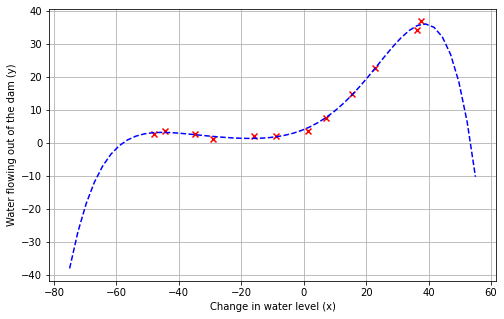

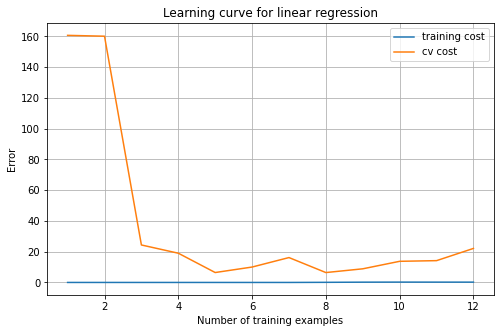

In [14]:
plotFit(train_means,train_stds,0)
learningCurve(X_norm,y,Xval_norm,yval,0)

## Adjusting the regularization parameter
上图可以看到λ = 0时，训练误差太小了，明显过拟合了。

我们继续调整λ = 1 时：


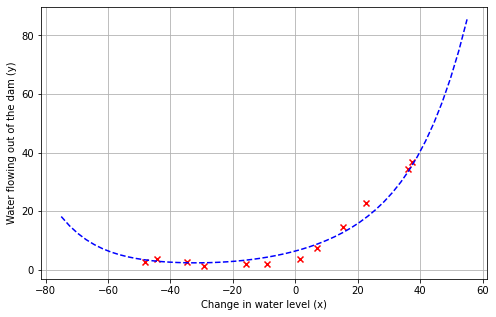

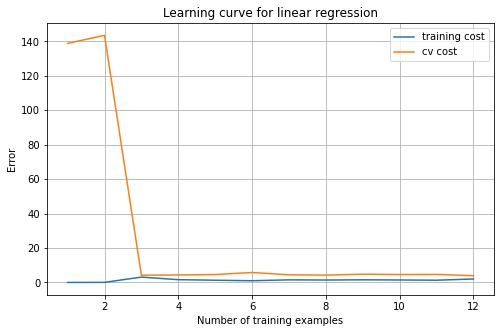

In [15]:
plotFit(train_means, train_stds, 1)
learningCurve(X_norm, y, Xval_norm, yval, 1)

我们继续调整λ = 100 时，很明显惩罚过多，欠拟合了

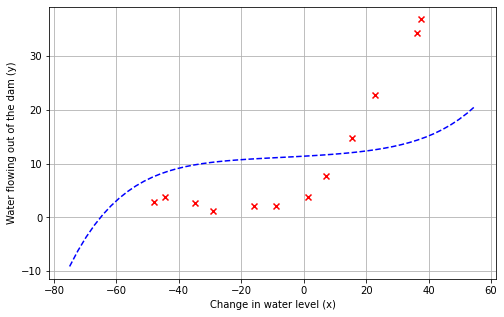

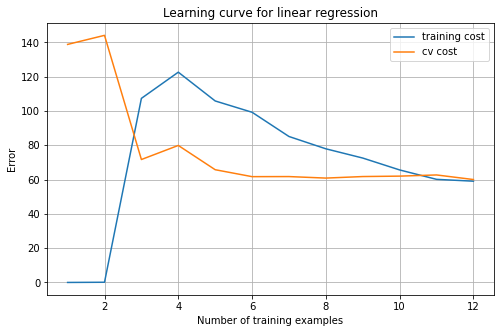

In [16]:
plotFit(train_means, train_stds, 100)
learningCurve(X_norm, y, Xval_norm, yval, 100)

## Selecting λ using a cross validation set

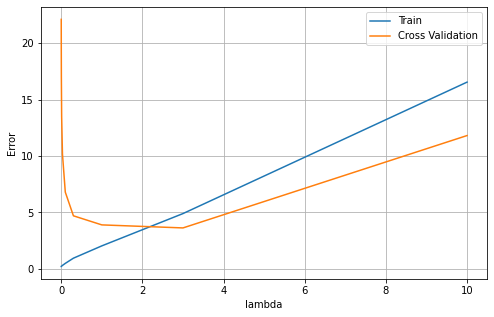

In [17]:
lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
errors_train, errors_val = [], []
for l in lambdas:
    theta = trainLinearReg(X_norm, y, l)
    errors_train.append(costReg(theta,X_norm,y,0))  # 记得把lambda = 0
    errors_val.append(costReg(theta,Xval_norm,yval,0))
    
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

In [18]:
# 可以看到时交叉验证代价最小的是 lambda = 3
lambdas[np.argmin(errors_val)]  # 3.0

3.0

## Computing test set error
In our cross validation, we obtained a test error of 3.8599 for λ = 3.

实际上我在上面调整了power=6来匹配作业里面的图，所以得不到3.8599。但是调整power=8时（同作业里一样）,就可以得到上述数据。

In [19]:
theta = trainLinearReg(X_norm, y, 3)
print('test cost(l={}) = {}'.format(3, costReg(theta, Xtest_norm, ytest, 0)))
# for l in lambdas:
#     theta = trainLinearReg(X_norm, y, l)
#     print('test cost(l={}) = {}'.format(l, costReg(theta, Xtest_norm, ytest, 0)))

test cost(l=3) = 4.755271985436194
